In [15]:
import os
import re
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shutil
from matplotlib.ticker import PercentFormatter

from count_functions import prepare_counts_import

In [16]:
print(os.getcwd())

C:\Users\Jonas\OneDrive - Johannes Kepler Universität Linz\UNI\5.Semester\SMM\recsys-bias-propagation-simulation


In [17]:
# uncomment for manual execution
'''
path = 'data/ChooseSome_ControlGroupDE/Only US Tracks chosen/ItemKNN_Martin_16-12-23_SMM_DEMO_controlGroupDE_onlyFromUS/' # has to have / at the end
odataset_path = f'data/ChooseSome_ControlGroupDE/Only US Tracks chosen/ItemKNN_Martin_16-12-23_SMM_DEMO_controlGroupDE_onlyFromUS/smm_demo_itemknn' #name of the original dataset has to have / at the end
filenames = 'smm_demo_itemknn'
model = 'ItemKNN' # name of the model
focus_country = 'US' # ~country code of the country the recommendations are for
country = 'DE'  # country code of the country to look at
control_country = 'DE' # country code of the control country
user_model = 'onlyFromUS' # name of the user model
'''
# Because the naming convention is not consistent, we need to do some additional preprocessing
if model.startswith('BlindSpotAware'):
    model = 'BlindSpotAware'
    filenames = filenames.split('blindspotaware')[0]+'blindspotaware'
    odataset_path = odataset_path.split('blindspotaware')[0]+'blindspotaware'


# Split the normalized path and get the category folder name
category_folder_name = os.path.normpath(path).split(os.sep)[2]
folder_name_mapping = {
    'BSC_Re_Ran - Randomly chose Top K': 'Randomly Chosen Top K',
    'No US Tracks chosen': 'No US Tracks',
    'Only DE Tracks chosen': 'Only DE Tracks',
    'Only US Tracks chosen': 'Only US Tracks',
    'Only from own Country': 'Only Local Country Tracks'
}

category_name = folder_name_mapping.get(category_folder_name, category_folder_name)

plt.rcParams['figure.figsize'] = [12, 5] # Sets the size of all plots
plt.rcParams['legend.fontsize'] = 10 # Sets the font size of all legends
plt.rcParams['legend.title_fontsize'] = 14 # Sets the font size of all legend titles
plt.rcParams['axes.labelsize'] = 22 # Sets the font size of all axis labels
plt.rcParams['xtick.labelsize'] = 20 # Sets the font size of all x-axis tick labels
plt.rcParams['ytick.labelsize'] = 20 # Sets the font size of all y-axis tick labels
plt.rcParams.update({'font.size': 22}) # Sets the font size of the rest of the text

tracks_file_path = os.path.join(odataset_path, 'tracks.txt.gz')

odataset_name = os.path.normpath(odataset_path).split(os.sep)[-2]

In [18]:
# Uncomment for automatic execution
print(model, user_model, country, focus_country, path, odataset_path, filenames)

ItemKNN onlyFromUS DE US data/ChooseSome_ControlGroupDE/Only US Tracks chosen/ItemKNN_Martin_16-12-23_SMM_DEMO_controlGroupDE_onlyFromUS/ data/ChooseSome_ControlGroupDE/Only US Tracks chosen/ItemKNN_Martin_16-12-23_SMM_DEMO_controlGroupDE_onlyFromUS/smm_demo_itemknn smm_demo_itemknn


In [19]:
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

def extract_number(s):
    match = re.search(r'_(\d+)$', s)
    if match:
        return int(match.group(1))
    return 0  # If no number is found, assume it is the base case (0th iteration)

def find_files(filename, search_path):
    result = []
    for root, dir, files in os.walk(search_path):
        if filename in files:
            result.append(os.path.join(root, filename))
    return result


def delete_last_unfinished_folder(current_model):
    # Identify the last subfolder
    subfolders = [ f.path for f in os.scandir(path) if f.is_dir() ]
    subfolders = sorted(subfolders, key=extract_number)
    last_subfolder = subfolders[-1] if subfolders else None
    
    # Check if the specific file exists in the last subfolder
    required_file = f'{current_model}_accepted_songs.txt'  # Modify this as needed
    if last_subfolder and not os.path.exists(os.path.join(last_subfolder, required_file)):
        print(f"Required file '{required_file}' not found in the last subfolder: {last_subfolder}. Deleting the folder.")
        shutil.rmtree(last_subfolder)  # Deletes the folder
        return subfolders[:-1]
    else:
        print(f"Required file '{required_file}' found in the last subfolder: {last_subfolder}.")
        return subfolders
    

subfolders = delete_last_unfinished_folder(model)

mode = 'unique'
save_as = f'{odataset_name}_{model}_{country}.jpg'

Required file 'ItemKNN_accepted_songs.txt' found in the last subfolder: data/ChooseSome_ControlGroupDE/Only US Tracks chosen/ItemKNN_Martin_16-12-23_SMM_DEMO_controlGroupDE_onlyFromUS/smm_demo_itemknn_23.


In [20]:
def get_single_country_proportions(counts: dict, country: str, mode: str = 'unique'):
    """
    Function to get proportions of counts for one country.
    Parameters
    ----------
    counts: Dictionary of counts for the imported music in one country
    country: Target country
    mode: mode of the counts

    Returns
    -------
    Proportion consmd focus_country (most often US) music, consmd local music, consmd other music
    """
    total_inters = 0
    for count in counts:
        total_inters += (counts[count][mode])

    focus_country_prop = counts[focus_country][mode] / total_inters
    local_prop = counts[country][mode] / total_inters
    others_prop = (total_inters - (counts[focus_country][mode] + counts[country][mode])) / total_inters
    return focus_country_prop, local_prop, others_prop

def get_baseline_proportions(interaction_file, track_file, user_file, local_country):
    # Read the baseline interaction data
    interactions = pd.read_csv(interaction_file, sep='\t', header=0, names=['uid', 'tid'])
    users = pd.read_csv(user_file, sep='\t', header=None, names=['country', 'age', 'gender', 'time'])
    tracks = pd.read_csv(track_file, sep='\t', header=None, names=['band', 'track', 'country'])
    
    # Merge the dataframes to get all information in one place
    merged_data = interactions.merge(tracks, left_on='tid', right_index=True).merge(users, left_on='uid', right_index=True)
    merged_data.replace({"UK": "GB"}, inplace=True)
    
    # Calculate the total number of interactions
    total_interactions = len(merged_data)
    
    # Calculate the number of interactions for focus_country (most often US) and local music
    focus_country_interactions = len(merged_data[merged_data['country_x'] == focus_country])
    local_interactions = len(merged_data[merged_data['country_x'] == local_country])  # Use 'country_x' for track country
    other_interactions = total_interactions - focus_country_interactions - local_interactions
    
    # Calculate the baseline proportions
    focus_country_baseline_proportion = focus_country_interactions / total_interactions if total_interactions > 0 else 0
    local_baseline_proportion = local_interactions / total_interactions if total_interactions > 0 else 0
    other_baseline_proportion = other_interactions / total_interactions if total_interactions > 0 else 0

    # For specific country - considering only users from the specified country or focus_country (most often US)
    country_specific_data = merged_data[merged_data['country_y'] == local_country]
    country_specific_total_interactions = len(country_specific_data)
    country_specific_focus_country_interactions = len(country_specific_data[country_specific_data['country_x'] == focus_country])
    country_specific_local_interactions = len(country_specific_data[country_specific_data['country_x'] == local_country])

    country_specific_focus_country_baseline = country_specific_focus_country_interactions / country_specific_total_interactions if country_specific_total_interactions > 0 else 0
    country_specific_local_baseline = country_specific_local_interactions / country_specific_total_interactions if country_specific_total_interactions > 0 else 0
    country_specific_other_baseline = (country_specific_total_interactions - country_specific_focus_country_interactions - country_specific_local_interactions) / country_specific_total_interactions if country_specific_total_interactions > 0 else 0

    return focus_country_baseline_proportion, local_baseline_proportion, other_baseline_proportion, country_specific_focus_country_baseline, country_specific_local_baseline, country_specific_other_baseline

# This revised version should more accurately calculate the baselines for global and country-specific data. 

def read_and_process_data(subfolders, odataset_path, country, mode):
    # Prepare the structure to store the calculated proportions
    value_dict = {focus_country: {}, 'local': {}, 'others': {}}

    # Determine the path to baseline files
    interaction_file = os.path.join(odataset_path, f'{filenames}.inter')
    track_file = os.path.join(odataset_path, 'tracks.txt.gz')
    user_file = os.path.join(odataset_path, 'demo.txt.gz')

    # Get the baseline proportions
    focus_country_baseline, local_baseline, other_baseline, country_focus_country_baseline, country_local_baseline, country_other_baseline = get_baseline_proportions(interaction_file, track_file, user_file, country)

    global_idx = 0

    for dir_path in subfolders:
        files = find_files(model+'_top_k.txt', dir_path)
        # print("files:", files)
        # files.sort(key=natural_keys)
        files.sort(key=natural_keys)

        for file in files:
            fi = pd.read_csv(file, sep='\t', header=0, names=['uid', 'tid', 'rank', 'score'])
            # Read user demographics
            fu = pd.read_csv(os.path.join(odataset_path, 'demo.txt.gz'), sep='\t', header=None, names=['country', 'age', 'gender', 'time'])
            fu["country"].replace({"UK": "GB"}, inplace=True)
            # Read track information
            ft = pd.read_csv(os.path.join(odataset_path, 'tracks.txt.gz'), sep='\t', header=None, names=['band', 'track', 'country'])
            counts_import = prepare_counts_import(fi, ft, fu, LEs=(mode == 'LEs'))
            # Calculate single country proportions
            focus_country_prop, local_prop, others_prop = get_single_country_proportions(counts_import[country], country, mode)
            # print(f"{focus_country}_prop:", focus_country_prop, "local_prop", local_prop, "others_prop", others_prop)


            value_dict[focus_country][global_idx] = focus_country_prop
            value_dict['local'][global_idx] = local_prop
            value_dict['others'][global_idx] = others_prop
            global_idx += 1

    # Return the value_dict and baseline proportions
    return value_dict, focus_country_baseline, local_baseline, other_baseline, country_focus_country_baseline, country_local_baseline, country_other_baseline

value_dict, focus_country_baseline, local_baseline, other_baseline, country_focus_country_baseline, country_local_baseline, country_other_baseline = read_and_process_data(subfolders, odataset_path, country, mode)

# New Plots

In [21]:
x_values = list(range(1, len(value_dict['local'])+1))
file_paths = [os.path.join(subfolder, f'{model}_accepted_songs.txt') for subfolder in subfolders]
y_focus_country = np.array([value_dict[focus_country][i] for i in range(len(value_dict[focus_country]))])
y_local = np.array([1 - value_dict['local'][i] for i in range(len(value_dict['local']))])

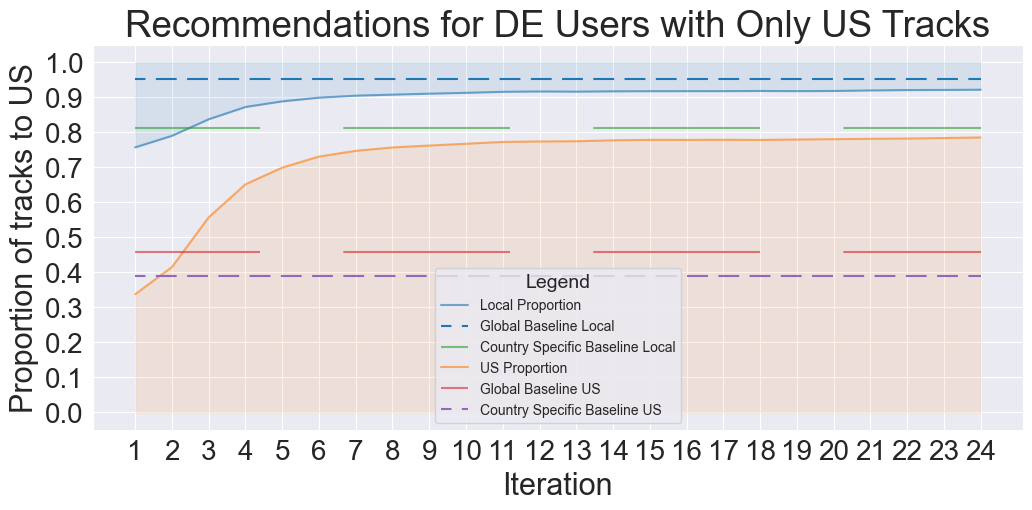

In [22]:
fig, ax = plt.subplots()

dashes = (20, (10, 5))
long_dashes = (20, (80, 40))

# Plot local and focus_country (most often US) values directly
ax.plot(x_values, y_local, label='Local Proportion', color='tab:blue', alpha=0.6)
ax.fill_between(x_values, 1, y_local, color='tab:blue', alpha=0.1)
ax.hlines(1 - np.mean(local_baseline), xmin=1, xmax=len(x_values), color='tab:blue', linestyle=dashes, label='Global Baseline Local', alpha=1, linewidth=1.5)
ax.hlines(1 - np.mean(country_local_baseline), xmin=1, xmax=len(x_values), color='tab:green', linestyle=long_dashes, label='Country Specific Baseline Local', alpha=0.6)

ax.plot(x_values, y_focus_country, label=f'{focus_country} Proportion', color='tab:orange', alpha=0.6)
ax.fill_between(x_values, y_focus_country, color='tab:orange', alpha=0.1)
ax.hlines(np.mean(focus_country_baseline), xmin=1, xmax=len(x_values), color='tab:red', linestyle=long_dashes, label=f'Global Baseline {focus_country}', alpha=0.6)
ax.hlines(np.mean(country_focus_country_baseline), xmin=1, xmax=len(x_values), color='tab:purple', linestyle=dashes, label=f'Country Specific Baseline {focus_country}', alpha=1, linewidth=1.5)


# Set x and y axis labels and title
ax.set_xlabel('Iteration')
ax.set_ylabel(f'Proportion of tracks to {focus_country}')
ax.set_title(f'Recommendations for {country} Users with {category_name}')

# Configure x and y axis ticks
plt.xticks(ticks=range(1, len(x_values) + 1), labels=x_values, rotation=0)

y_tick_values = np.linspace(0, 1, num=11)
ax.set_yticks(y_tick_values)
ax.set_yticklabels(["{:.1f}".format(y) for y in y_tick_values])

ax.legend(loc='lower center', title='Legend')
ax.set_xlabel('Iteration')
ax.set_ylabel(f'Proportion of tracks to {focus_country}')

ax.tick_params(axis='x')
ax.tick_params(axis='y')

save_path = os.path.join(path, f'{model}_{country}.jpg')

plt.show()

<Figure size 1200x500 with 0 Axes>

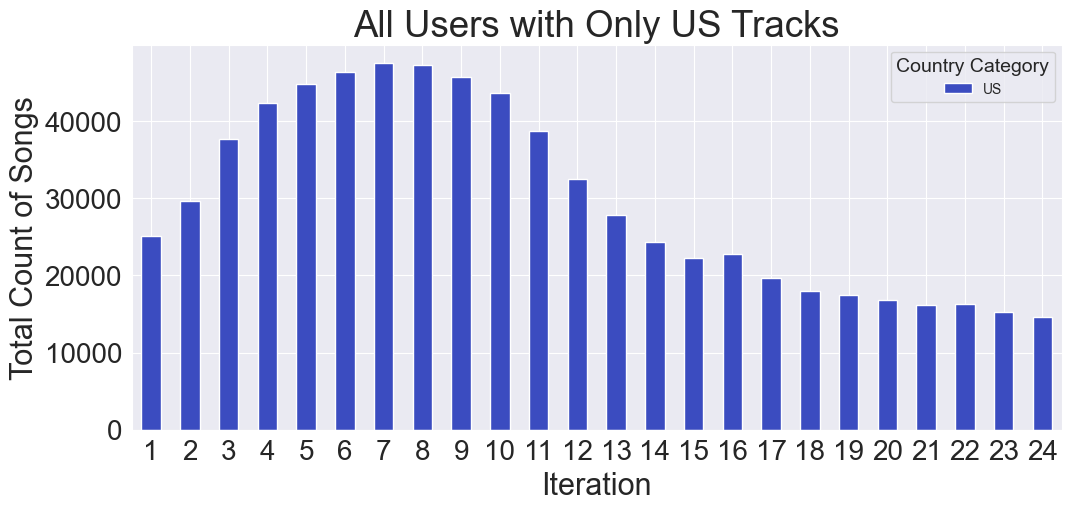

In [23]:
# Function to read CSV or gzipped files
def read_csv(file_path, names, skiprows=1, gzipped=False):
    if gzipped:
        return pd.read_csv(file_path, sep='\t', skiprows=skiprows, header=None, names=names, compression='gzip')
    else:
        return pd.read_csv(file_path, sep='\t', skiprows=skiprows, header=None, names=names)

# Function to categorize countries
def categorize_countries(row, country_mapping, specific_country):
    country_code = country_mapping.get(row['song_id'])
    if country_code == focus_country:
        return focus_country
    elif country_code == specific_country:
        return specific_country
    else:
        return 'Other'

# Function to process and aggregate songs
def process_songs(file_paths, users_filter=None):
    data = pd.DataFrame()
    for i, file_path in enumerate(file_paths, start=0):
        song_counts = read_csv(file_path, names=['user_id', 'song_id'])
        if users_filter is not None:
            song_counts = song_counts[song_counts['user_id'].isin(users_filter)]
        # If this crashes, update pandas. If this doesn't help update everything else.
        song_counts = song_counts['song_id'].value_counts().reset_index().rename(columns={'index': 'song_id'})
        data = pd.concat([data, song_counts.assign(iteration=i)])
    return data


# Reading files and processing data
tracks_contents = read_csv(tracks_file_path, names=['band', 'track', 'country'], skiprows=0, gzipped=True)
song_id_to_country = {i: row['country'] for i, row in tracks_contents.iterrows()}
inter_df = read_csv(os.path.join(odataset_path, filenames+'.inter'), names=['user_id', 'song_id'])
demo_df = read_csv(os.path.join(odataset_path, 'demo.txt.gz'), names=['country', 'age', 'gender', 'timestamp'], gzipped=True, skiprows=0)
demo_df["country"].replace({"UK": "GB"}, inplace=True)
demo_df.reset_index(inplace=True)
demo_df['user_id'] = demo_df.index

# Merging and filtering data
merged_data = pd.merge(inter_df, demo_df, on='user_id')
german_user_ids = merged_data[merged_data['country'] == country]['user_id'].unique()

# Processing and categorizing song data
all_data = process_songs(file_paths)
german_data = process_songs(file_paths, german_user_ids)
all_data['country_category'] = all_data.apply(lambda row: categorize_countries(row, song_id_to_country, country), axis=1)
german_data['country_category'] = german_data.apply(lambda row: categorize_countries(row, song_id_to_country, country), axis=1)

# Creating pivot tables and plotting
pivot_all = all_data.pivot_table(index='iteration', columns='country_category', values='count', aggfunc='sum', fill_value=0)

# Plot for All Users
plt.figure()
pivot_all.plot(kind='bar', stacked=True, colormap='coolwarm')
plt.title(f'All Users with {category_name}')
plt.xlabel('Iteration')
plt.xticks(ticks=range(len(x_values)), labels=x_values, rotation=0)
plt.ylabel('Total Count of Songs')
plt.legend(title='Country Category')
plt.show()

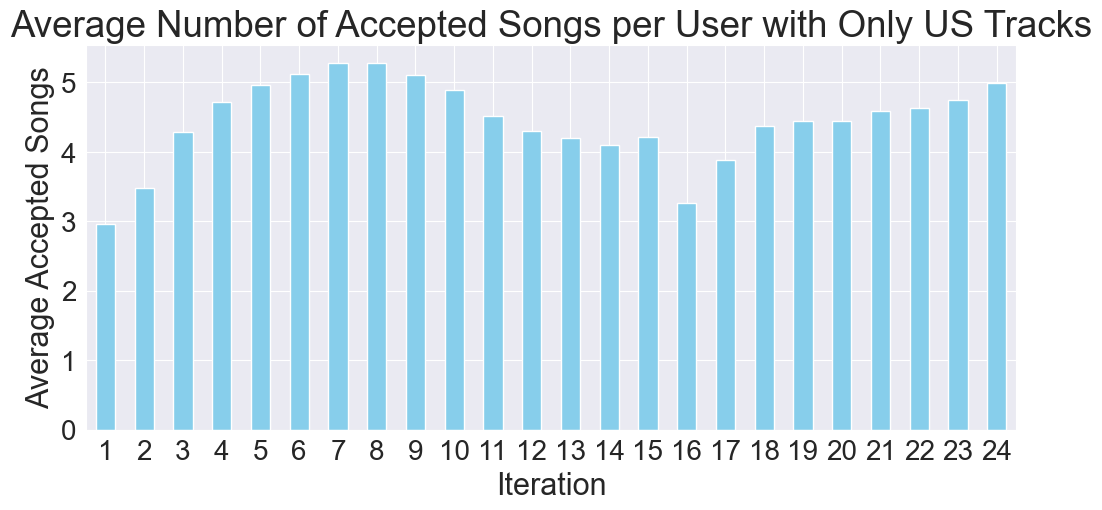

In [24]:
# Calculate the number of accepted songs per user per iteration
def accepted_songs_per_user(file_paths):
    accepted_per_user = pd.DataFrame()
    for i, file_path in enumerate(file_paths, start=1):
        # Read the accepted songs for this iteration
        iteration_data = read_csv(file_path, names=['user_id', 'song_id'])
        # Count the number of accepted songs per user
        user_song_counts = iteration_data.groupby('user_id').size().reset_index(name='accepted_count')
        # Include the iteration number in the dataframe
        user_song_counts['iteration'] = i
        # Concatenate the data for this iteration to the overall dataframe
        accepted_per_user = pd.concat([accepted_per_user, user_song_counts], ignore_index=True)
    return accepted_per_user

# Calculate the accepted songs per user for all iterations
accepted_songs_data = accepted_songs_per_user(file_paths)

# Calculate the total number of accepted songs and the total number of users per iteration
total_accepted_per_iteration = accepted_songs_data.groupby('iteration')['accepted_count'].sum()
total_users_per_iteration = accepted_songs_data.groupby('iteration')['user_id'].nunique()

# Calculate the average number of accepted songs per user per iteration
avg_accepted_per_user = total_accepted_per_iteration / total_users_per_iteration

# Plotting the average number of accepted songs per user per iteration
plt.figure()
avg_accepted_per_user.plot(kind='bar', color='skyblue')
plt.title(f'Average Number of Accepted Songs per User with {category_name}')
plt.xlabel('Iteration')
plt.ylabel('Average Accepted Songs')
plt.xticks(ticks=range(len(x_values)), labels=x_values, rotation=0)
plt.show()


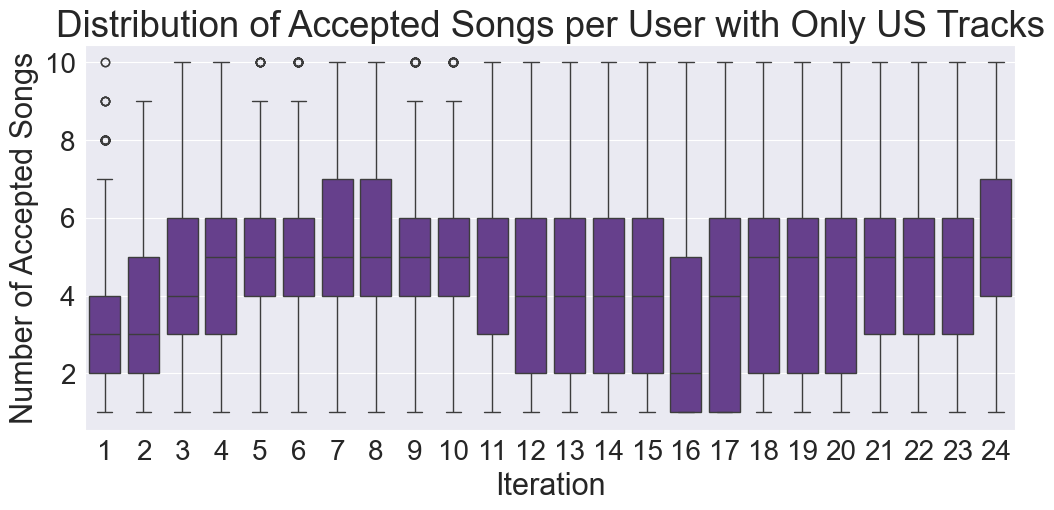

In [25]:
# Function to get the count of accepted songs per user for each iteration
def accepted_songs_distribution(file_paths):
    distribution_data = pd.DataFrame()
    for i, file_path in enumerate(file_paths, start=1):
        # Read the accepted songs for this iteration
        iteration_data = read_csv(file_path, names=['user_id', 'song_id'])
        # Count the number of accepted songs per user
        user_song_counts = iteration_data.groupby('user_id').size().reset_index(name='accepted_count')
        # Include the iteration number in the dataframe
        user_song_counts['iteration'] = i
        # Concatenate the data for this iteration to the overall dataframe
        distribution_data = pd.concat([distribution_data, user_song_counts], ignore_index=True)
    return distribution_data

# Calculate the distribution of accepted songs per user for all iterations
accepted_distribution_data = accepted_songs_distribution(file_paths)

# Plotting the boxplot for the distribution of accepted songs per user per iteration
plt.figure()
sns.boxplot(x='iteration', y='accepted_count', data=accepted_distribution_data, color='rebeccapurple')  # Set the color of the boxplot directly
plt.title(f'Distribution of Accepted Songs per User with {category_name}')
plt.xlabel('Iteration')
plt.xticks(ticks=range(len(x_values)), labels=x_values, rotation=0)
plt.ylabel('Number of Accepted Songs')
plt.show()


In [26]:
from tqdm.notebook import tqdm


def merge_with_user_country(data, user_demo_data, country):
    return data.merge(user_demo_data[user_demo_data['country'] == country], on='user_id')

def aggregate_popularity_data():
    popularity_lift_data = {
        'input_vs_recs': [],
        'input_vs_accepted': [],
        'recs_vs_accepted': [],
        'input_vs_recs_control_country': [],
        'input_vs_accepted_control_country': [],
        'recs_vs_accepted_control_country': [],
    }
    popularity_data = {
        'training': [],
        #'recommendations': [],
        #'recommendations_country': [],
        #'accepted_songs': [],
        #'accepted_songs_country': [],
        #'recommendations_control_country': [],
        #'accepted_songs_control_country': [],
    }

    for subfolder in subfolders:
        iteration_number = extract_number(subfolder)  
        
        inter_file_path = os.path.join(subfolder, f'{filenames}_{iteration_number}.train.inter') if iteration_number > 0 else os.path.join(subfolder, f'{filenames}.train.inter')
        recommendations_file_path = find_files(model+'_top_k.txt', subfolder)[0]  
        accepted_songs_file_path = find_files(f'{model}_accepted_songs.txt', subfolder)[0]

        # Read data
        training_data = read_csv(inter_file_path, names=['user_id', 'song_id', 'interaction_value'])
        recommendations_data = read_csv(recommendations_file_path, names=['user_id', 'song_id', 'rank', 'score'])
        accepted_songs_data = read_csv(accepted_songs_file_path, names=['user_id', 'song_id'])
    
        # Calculate song popularity for this iteration
        pop_lookup = training_data['song_id'].value_counts()
        training_data['song_popularity'] = training_data['song_id'].map(pop_lookup)
        recommendations_data['song_popularity'] = recommendations_data['song_id'].map(pop_lookup)
        accepted_songs_data['song_popularity'] = accepted_songs_data['song_id'].map(pop_lookup)
        
        # Popularity lift
        
        user_pop = training_data.groupby('user_id')['song_popularity'].mean()
        rec_pop = recommendations_data.groupby('user_id')['song_popularity'].mean()
        acc_pop = accepted_songs_data.groupby('user_id')['song_popularity'].mean()
        popularity_lift_data['input_vs_recs'].append(((rec_pop - user_pop) / user_pop).mean())
        popularity_lift_data['input_vs_accepted'].append(((acc_pop - user_pop) / user_pop).mean())
        popularity_lift_data['recs_vs_accepted'].append(((acc_pop - rec_pop) / rec_pop).mean())
        
        user_pop_cc = training_data[training_data['user_id'].isin(german_user_ids)].groupby('user_id')['song_popularity'].mean()
        rec_pop_cc = recommendations_data[recommendations_data['user_id'].isin(german_user_ids)].groupby('user_id')['song_popularity'].mean()
        acc_pop_cc = accepted_songs_data[accepted_songs_data['user_id'].isin(german_user_ids)].groupby('user_id')['song_popularity'].mean()
        popularity_lift_data['input_vs_recs_control_country'].append(((rec_pop_cc - user_pop_cc) / user_pop_cc).mean())
        popularity_lift_data['input_vs_accepted_control_country'].append(((acc_pop_cc - user_pop_cc) / user_pop_cc).mean())
        popularity_lift_data['recs_vs_accepted_control_country'].append(((acc_pop_cc - rec_pop_cc) / rec_pop_cc).mean())
        
        
        
        # TODO the following implementation is wrong: it calculates the popularities within the recommendations, not the true popularities based on the interactions
        training_popularity = training_data['song_id'].value_counts(sort=False)
        popularity_data['training'].append(training_popularity)
        """
        recommendations_popularity = recommendations_data['song_id'].value_counts().reset_index(drop=True)
        accepted_songs_popularity = accepted_songs_data['song_id'].value_counts().reset_index(drop=True)
    
        # Now merge using the 'user_id' as a common column
        recommendations_country_data = recommendations_data.merge(demo_df[demo_df['country'] == country], on='user_id')
        accepted_songs_country_data = accepted_songs_data.merge(demo_df[demo_df['country'] == country], on='user_id')

        recommendations_control_country_data = recommendations_data.merge(demo_df[demo_df['country'] == control_country], on='user_id')
        accepted_songs_control_country_data = accepted_songs_data.merge(demo_df[demo_df['country'] == control_country], on='user_id')
        
        # Append the popularity counts to the respective lists in the dictionary
        popularity_data['recommendations'].append(recommendations_popularity)
        popularity_data['accepted_songs'].append(accepted_songs_popularity)
        popularity_data['recommendations_country'].append(recommendations_country_data['song_id'].value_counts())
        popularity_data['accepted_songs_country'].append(accepted_songs_country_data['song_id'].value_counts())
        popularity_data['recommendations_control_country'].append(recommendations_control_country_data['song_id'].value_counts())
        popularity_data['accepted_songs_control_country'].append(accepted_songs_control_country_data['song_id'].value_counts())
        """
    return popularity_data, popularity_lift_data

popularity_data, popularity_lift_data = aggregate_popularity_data()

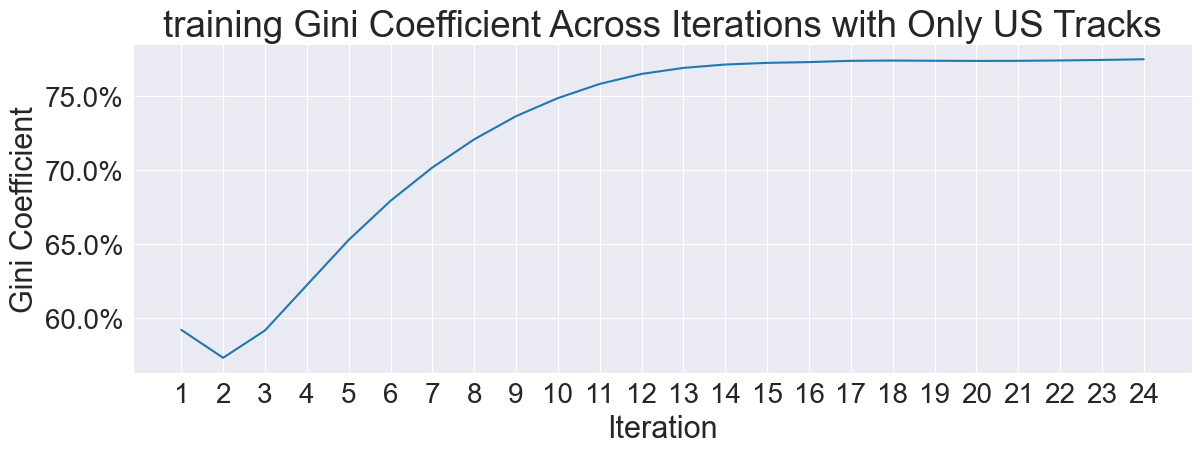

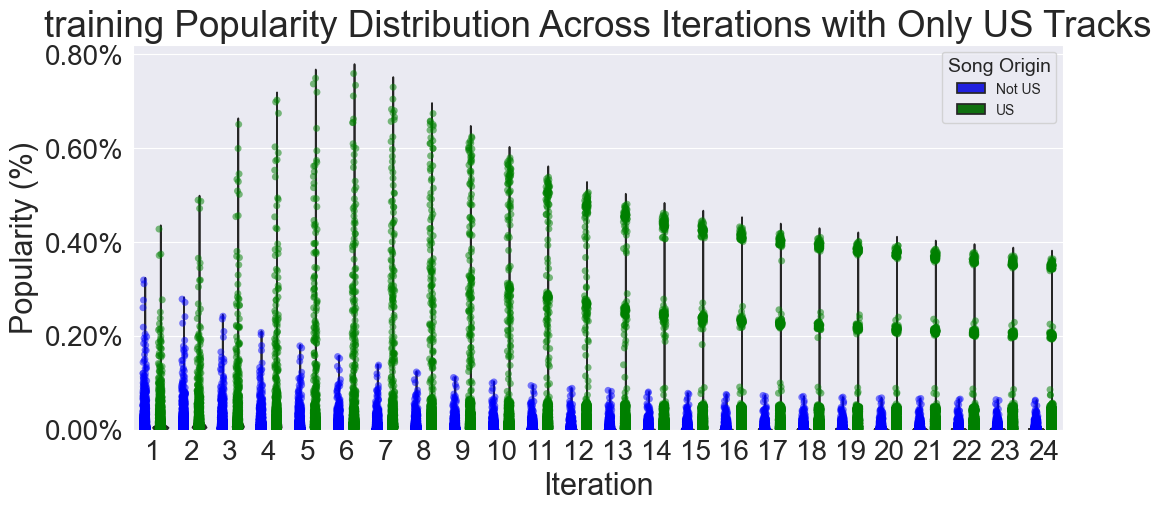

In [27]:
def gini_numpy(array):
    if len(array) == 0:  # Check if the array is empty
        return 0

    array = np.array(array, dtype=np.float64)
    array = array.flatten()  # Flatten in case it is not 1D already.
    if np.amin(array) < 0:
        array -= np.amin(array)
    array = np.sort(array)

    index = np.arange(1, array.shape[0] + 1)
    n = array.shape[0]
    return (np.sum((2 * index - n - 1) * array)) / (n * np.sum(array))

def calculate_gini_coefficients(popularity_list):
    gini_coefficients = [gini_numpy(counts.values) for counts in popularity_list]
    return gini_coefficients

def prepare_plot_data(popularity_list, gini_coefficients):
    # Convert popularity counts to percentages
    def to_percentages(counts):
        total = sum(counts)
        return [count / total * 100 for count in counts]
    
    df = pd.DataFrame({
    'Popularity': [popularity for counts in popularity_list for popularity in to_percentages(list(counts))],
    'Iteration': [iteration + 1 for iteration, counts in enumerate(popularity_list) for _ in range(len(counts))],
    'Song ID': [song_id for counts in popularity_list for song_id in counts.index],
    f'{focus_country} Song': [focus_country if song_id_to_country.get(song_id, f'Not {focus_country}') == focus_country else f'Not {focus_country}' for counts in popularity_list for song_id in counts.index]
    })
    #for counts in popularity_list:
    #    for song_id in counts.index:
    #        if song_id_to_country.get(song_id, f'Not {focus_country}') == focus_country:
    #            print(song_id_to_country.get(song_id, f'Not {focus_country}'))
    
    df_gini = pd.DataFrame({
        'Gini Coefficient': [coefficient*100 for coefficient in gini_coefficients],
        'Iteration': x_values
    })

    return df, df_gini


def plot_popularity_and_gini(df, df_gini, data_category_name, focus_country):
    # Plot for Gini Coefficients
    plt.figure()
    sns.lineplot(x='Iteration', y='Gini Coefficient', data=df_gini)
    plt.title(f'{data_category_name} Gini Coefficient Across Iterations with {category_name}')
    plt.xlabel('Iteration')
    plt.ylabel('Gini Coefficient')
    plt.xticks(ticks=range(1, len(x_values) + 1), labels=x_values, rotation=0)
    plt.tight_layout()
    plt.gca().yaxis.set_major_formatter(PercentFormatter())
    plt.show()

    # Plot for Popularity Distribution
    plt.figure()
    sns.violinplot(x='Iteration', y='Popularity', hue=f'{focus_country} Song', data=df, palette={focus_country: 'green', f'Not {focus_country}': 'blue'}, inner='quartile')
    sns.stripplot(x='Iteration', y='Popularity', hue=f'{focus_country} Song', data=df, palette={focus_country: 'green', f'Not {focus_country}': 'blue'}, dodge=True, jitter=True, alpha=0.5)
    plt.title(f'{data_category_name} Popularity Distribution Across Iterations with {category_name}')
    plt.xlabel('Iteration')
    plt.ylabel('Popularity (%)')
    #plt.xticks(ticks=range(1, len(x_values) + 1), labels=x_values, rotation=0)

    # Update the legend
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles=handles[:2], labels=[f'Not {focus_country}', focus_country], title='Song Origin')

    # Set y-axis to percentage format
    plt.gca().yaxis.set_major_formatter(PercentFormatter())

    plt.ylim(bottom=0)
    plt.show()

# Implementing the plotting for each category
for data_category_name, data in popularity_data.items():
    gini_coefficients = calculate_gini_coefficients(data)
    df, df_gini = prepare_plot_data(data, gini_coefficients)
    plot_popularity_and_gini(df, df_gini, data_category_name, focus_country)


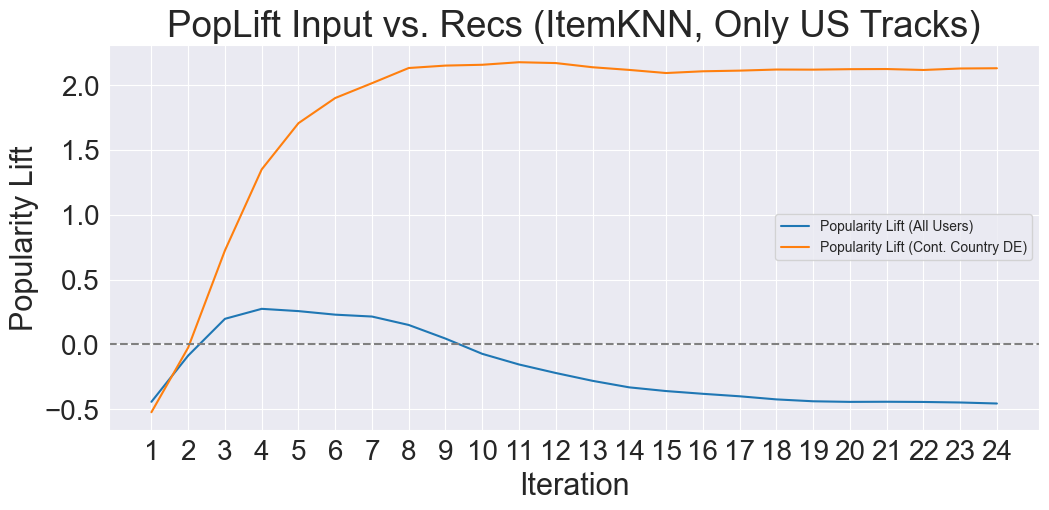

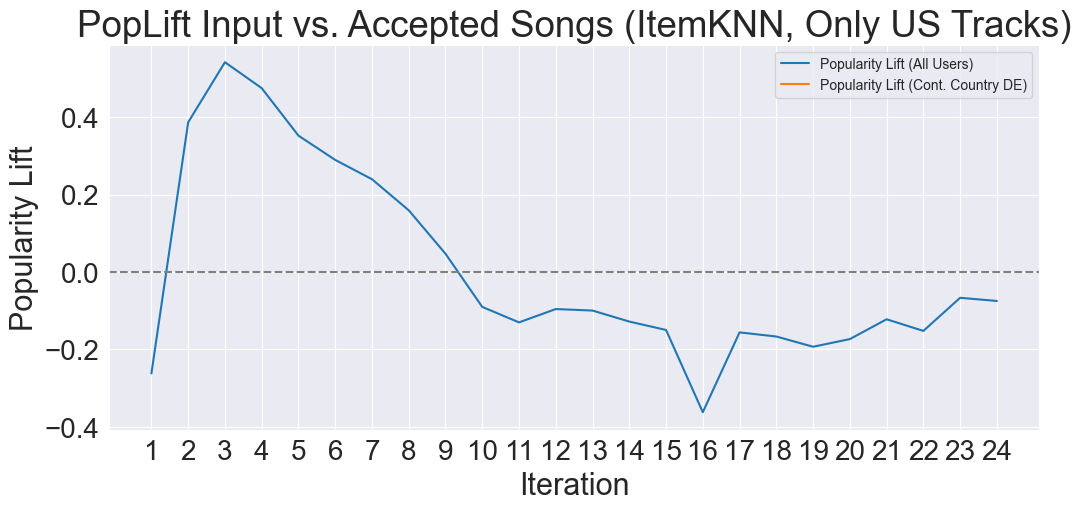

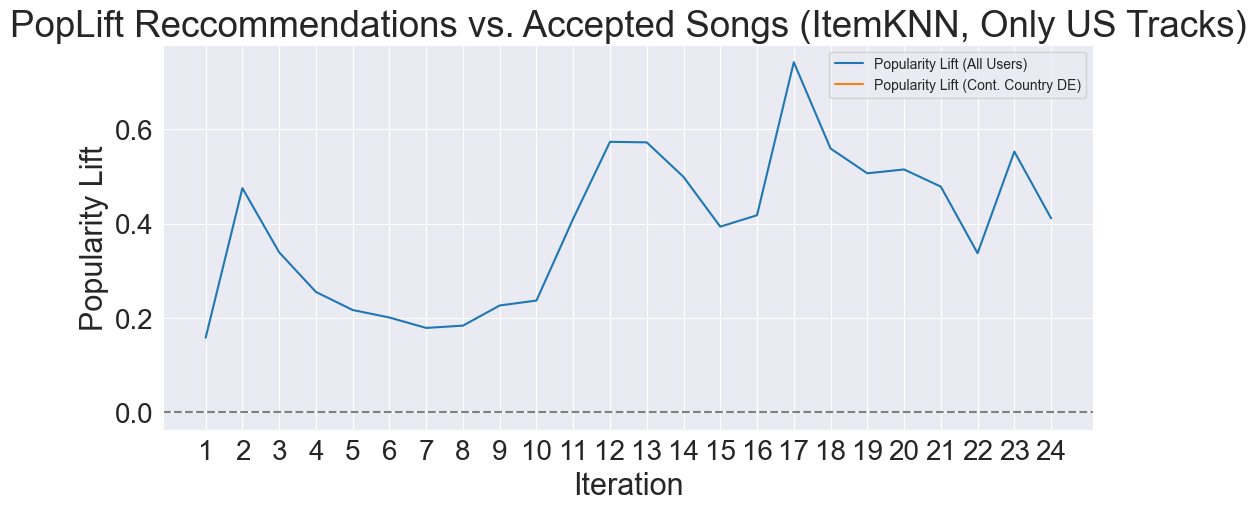

In [28]:
# Popularity Lift Input data vs. Recommendations
plt.figure()
plt.plot(popularity_lift_data['input_vs_recs'], label='Popularity Lift (All Users)')
plt.plot(popularity_lift_data['input_vs_recs_control_country'], label=f'Popularity Lift (Cont. Country {control_country})')
plt.xlabel('Iteration')
plt.ylabel('Popularity Lift')
plt.title(f'PopLift Input vs. Recs ({model}, {category_name})')
plt.axhline(0.0, color='grey', linestyle='--')
plt.xticks(ticks=range(len(x_values)), labels=x_values, rotation=0)
plt.legend()
plt.show()

# Popularity Lift Input data vs. Accepted Songs
plt.figure()
plt.plot(popularity_lift_data['input_vs_accepted'], label='Popularity Lift (All Users)')
plt.plot(popularity_lift_data['input_vs_accepted_control_country'], label=f'Popularity Lift (Cont. Country {control_country})')
plt.xlabel('Iteration')
plt.ylabel('Popularity Lift')
plt.title(f'PopLift Input vs. Accepted Songs ({model}, {category_name})')
plt.axhline(0.0, color='grey', linestyle='--')
plt.xticks(ticks=range(len(x_values)), labels=x_values, rotation=0)
plt.legend()
plt.show()

# Popularity Lift Recommendations vs. Accepted Songs
plt.figure()
plt.plot(popularity_lift_data['recs_vs_accepted'], label='Popularity Lift (All Users)')
plt.plot(popularity_lift_data['recs_vs_accepted_control_country'], label=f'Popularity Lift (Cont. Country {control_country})')
plt.xlabel('Iteration')
plt.ylabel('Popularity Lift')
plt.title(f'PopLift Reccommendations vs. Accepted Songs ({model}, {category_name})')
plt.axhline(0.0, color='grey', linestyle='--')
plt.xticks(ticks=range(len(x_values)), labels=x_values, rotation=0)
plt.legend()
plt.show()